In [2]:
import pandas as pd

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd

### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# Dask 데이터프레임으로 CSV 파일 읽기 (dtype 매개변수로 version 열을 문자열로 지정)
merged_wildfire_df = dd.read_csv(
    "./USA data/merged_wildfire_weather.csv", 
    dtype={'version': 'object'}  # version 열은 문자열로 처리
)

# Dask 데이터프레임의 일부 데이터를 확인 (head()는 지연 계산되므로 실제로 실행하려면 compute()가 필요함)
print(merged_wildfire_df.head())  # .compute()를 사용하지 않으면 미리보기만 가능

# Dask로 데이터 타입 변환 (datetime 변환)
merged_wildfire_df['datetime'] = dd.to_datetime(merged_wildfire_df['datetime'])

# 결측치 확인
print(merged_wildfire_df.isnull().sum().compute())  # 실제 결측치 개수를 확인하려면 compute()가 필요

# 불필요한 컬럼 삭제
columns_to_drop = [
    'scan', 'track', 'satellite', 'instrument', 'version', 'type'
]

merged_wildfire_df = merged_wildfire_df.drop(columns=columns_to_drop)

# 처리 후 정보 확인
print(merged_wildfire_df.info())  # compute()가 필요하지 않음, Dask 데이터프레임의 정보만 확인 가능

   latitude  longitude  brightness  scan  track    acq_date satellite  \
0  40.12655  -80.99725      322.99  0.42   0.61  2015-01-01         N   
1  40.75163  -81.44097      335.90  0.45   0.63  2015-01-01         N   
2  39.93786  -76.81354      301.80  0.51   0.49  2015-01-01         N   
3  37.23229  -82.03670      295.38  0.46   0.64  2015-01-01         N   
4  36.35398  -76.80887      301.27  0.46   0.47  2015-01-01         N   

  instrument confidence version  bright_t31   frp daynight  type   T2M  WS2M  \
0      VIIRS          n       2      265.48  3.25        N   0.0  1.23  0.66   
1      VIIRS          n       2      264.78  3.97        N   0.0  1.23  0.66   
2      VIIRS          n       2      267.25  0.80        N   2.0  1.23  0.66   
3      VIIRS          n       2      268.12  0.83        N   2.0  1.23  0.66   
4      VIIRS          n       2      272.02  1.35        N   2.0  1.23  0.66   

    RH2M  PRECTOTCORR             datetime  
0  43.37          0.0  2015-01-01 0

In [4]:
# 결측치 확인
print(merged_wildfire_df.isnull().sum().compute())  # 다시 계산하여 확인

latitude       0
longitude      0
brightness     0
acq_date       0
confidence     0
bright_t31     0
frp            0
daynight       0
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
datetime       0
dtype: int64


### 이상치 처리하기

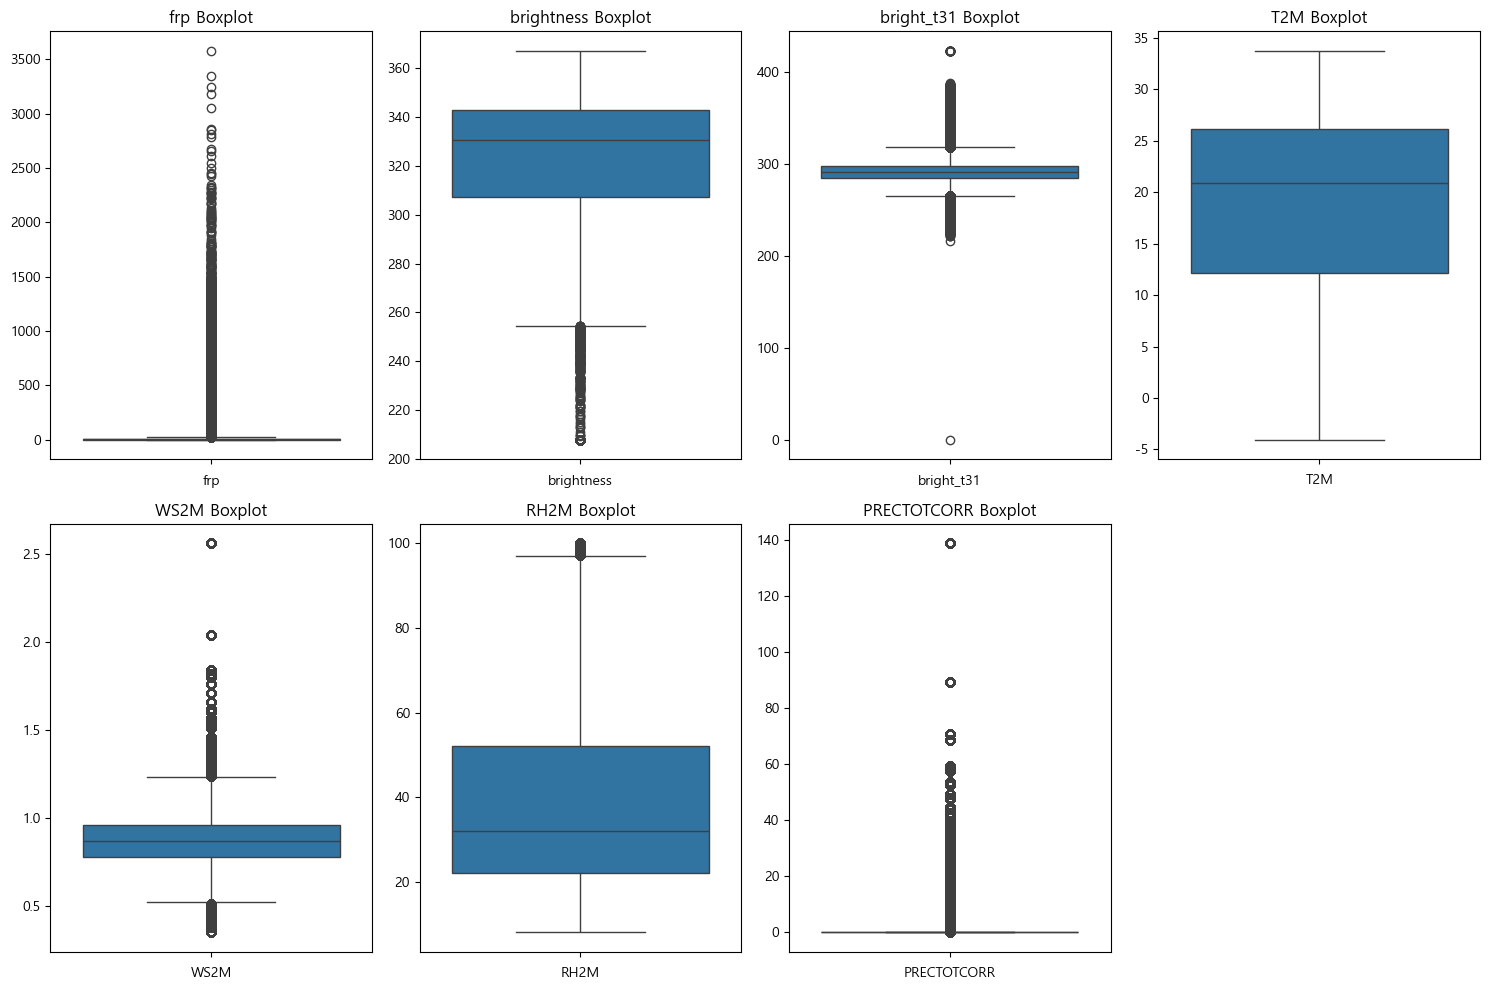

In [6]:
# 여러 변수에 대해 boxplot을 한 번에 그리기
plt.figure(figsize=(15, 10))

# 각 변수에 대해 Boxplot 생성
variables = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
for i, v in enumerate(variables, 1):
    plt.subplot(2, 4, i) # 2행 4열
    sns.boxplot(merged_wildfire_df[v])
    plt.title(f"{v} Boxplot")
    plt.xlabel(v)

plt.tight_layout()
plt.show()


In [ ]:
# IQR 계산 및 이상치 처리
def calculate_iqr(df, columns):
    iqr_results = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        iqr_results[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outliers': outliers
        }
    
    return iqr_results

columns_to_check = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]

# Dask에서는 compute()를 호출해야 실제 연산이 이루어짐
merged_df = merged_wildfire_df.compute()  # Dask 데이터프레임을 pandas로 변환

iqr_results = calculate_iqr(merged_df, columns_to_check)
for col, result in iqr_results.items():
    print(f"Column: {col}")
    print(f"  Q1: {result['Q1']}")
    print(f"  Q3: {result['Q3']}")
    print(f"  IQR: {result['IQR']}")
    print(f"  Lower Bound: {result['Lower Bound']}")
    print(f"  Upper Bound: {result['Upper Bound']}")
    print(f"  Outliers Count: {result['Outliers Count']}")
    print("")


In [ ]:

# 이상치 처리 함수
def handle_outliers(df):
    # FRP (Fire Radiative Power) 처리
    df['frp'] = df['frp'].clip(lower=0)  # FRP는 0 이상만 유지
    # Brightness 처리: 너무 낮거나 높은 값만 클리핑
    df['brightness'] = df['brightness'].clip(lower=254.43, upper=395.67)
    # Bright_t31 처리
    df['bright_t31'] = df['bright_t31'].clip(lower=265.0, upper=318.44)
    # T2M (기온)은 이상치가 없으므로 그대로 둡니다.
    # WS2M (2m 높이 풍속) 처리: 상한선만 설정
    df['WS2M'] = df['WS2M'].clip(upper=1.23)  # WS2M의 상한선만 설정 (하한선은 필요하지 않음)
    # RH2M (2m 높이 상대습도) 처리
    df['RH2M'] = df['RH2M'].clip(upper=100)  # RH2M의 상한선을 100으로 클리핑 (100%를 초과하는 값은 오류일 가능성 있음)
    # PRECTOTCORR (교정된 총 강수량)은 그대로 둠
    return df


# 이상치 처리
cleaned_wildfire_df = handle_outliers(merged_df)

# 처리 후 데이터 확인
print(cleaned_wildfire_df[['frp', 'brightness', 'bright_t31', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR']].head())

# 저장 (필요한 경우)
merged_df.to_csv("./USA data/cleaned_wildfire.csv", index=False)



In [ ]:
# 선택한 컬럼들로 Pairplot 시각화
selected_columns = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
sns.pairplot(cleaned_wildfire_df[selected_columns])
plt.show()

In [ ]:
# 상관 관계 시각화
corr = cleaned_wildfire_df.drop(columns=["acq_date", "confidence", "daynight", "datetime"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# 산불 데이터의 분포 확인
sns.boxplot(x="daynight", y="frp", data=cleaned_wildfire_df)
sns.boxplot(x="daynight", y="brightness", data=cleaned_wildfire_df)

# 산불 강도(frp)의 분포 확인
sns.histplot(cleaned_wildfire_df['frp'], kde=True)
plt.title("FRP(화력) 분포")
plt.show()


In [ ]:
# 기상 변수의 분포 확인
sns.histplot(cleaned_wildfire_df["T2M"], kde=True)
plt.title('온도(T2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['WS2M'], kde=True)
plt.title('풍속(WS2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['RH2M'], kde=True)
plt.title('상대습도(RH2M) 분포')
plt.show()

sns.histplot(cleaned_wildfire_df['PRECTOTCORR'], kde=True)
plt.title('강수량(PRECTOTCORR) 분포')
plt.show()

In [ ]:
# 날짜와 시간대별 분포 분석
cleaned_wildfire_df["acq_date"] = pd.to_datetime(cleaned_wildfire_df["acq_date"])
cleaned_wildfire_df["year"] = cleaned_wildfire_df["acq_date"].dt.year
cleaned_wildfire_df["month"] = cleaned_wildfire_df["acq_date"].dt.month
cleaned_wildfire_df["day"] = cleaned_wildfire_df["acq_date"].dt.day

# 월별 화재 방사 전력(FRP) 분석
sns.boxplot(x="month", y="frp", data=cleaned_wildfire_df)
plt.title("월간 화재 방사 전력(FRP)")
plt.show()

# 월별 기온(T2M) 분석
sns.boxplot(x="month", y="T2M", data=cleaned_wildfire_df)
plt.title("월간 기온 (T2M)")
plt.show()

In [ ]:
# 기온(T2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="T2M", y="frp", data=cleaned_wildfire_df)
plt.title("Temperature vs FRP")
plt.show()

# 풍속(WS2M)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="WS2M", y="frp", data=cleaned_wildfire_df)
plt.title("Wind Speed vs FRP")
plt.show()

# 상대 습도(RH2M)와 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="RH2M", y="frp", data=cleaned_wildfire_df)
plt.title("Relative Humidity vs FRP")
plt.show()

# 강수량(PRECTOTCORR)과 화재 방사 전력(FRP) 간의 관계
sns.scatterplot(x="PRECTOTCORR", y="frp", data=cleaned_wildfire_df)
plt.title("Precipitation vs FRP")
plt.show()

In [ ]:
# 산불 발생 지역 시각화 (위도, 경도)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=cleaned_wildfire_df, hue='frp', palette='coolwarm', size='frp', sizes=(10, 200))
plt.title('산불 발생 지역 (FRP)')
plt.show()
